# 1. 특성 추출(Feature Extraction)

1. 사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 흥미로운 특성을 뽑아내는 것

2. 컨브넷: 연속된 합성곱과 풀링 층으로 시작해 완전 연결 분류기로 끝남

3. 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반 층을 선택하여 새로운 데이터를 통과시키고 그 출력으로 새로운 분류기를 훈련
    
    3.1 합성곱 층만 재사용 하는 이유: 합성곱 층에 의해 학습된 표현이 일반적이어서 재사용 가능하기 때문

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# VGG16 Model

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top = False,
                 input_shape = (150, 150, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## 데이터 증식을 사용하지 않는 빠른 특성 추출

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
base_dir = '/content/drive/MyDrive/DataSets/cat dog/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) #last layer have (None, 4, 4, 512)
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 17ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 18ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 20ms/step


In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(learning_rate=2e-5), loss = 'binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 6ms/step - loss: 0.6121 - acc: 0.6460 - val_loss: 0.4795 - val_acc: 0.7820
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.4271 - acc: 0.8235 - val_loss: 0.3690 - val_acc: 0.8620
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3534 - acc: 0.8495 - val_loss: 0.3272 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3233 - acc: 0.8620 - val_loss: 0.3073 - val_acc: 0.8820
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2820 - acc: 0.8895 - val_loss: 0.2913 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2631 - acc: 0.8985 - val_loss: 0.2764 - val_acc: 0.8860
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2524 - acc: 0.8940 - val_loss: 0.2686 - val_acc: 0.8940
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

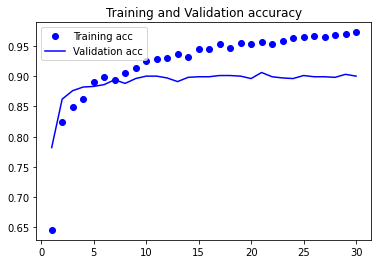

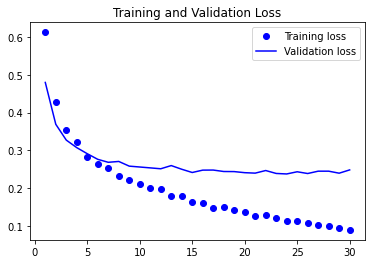

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

기존 모델보다는 훨씬 좋아졌으나 과대적합을 피하지 못함, 데이터 증식을 사용하지 않아서임

## 2. 데이터 증식을 사용한 특성 추출

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수: ', len(model.trainable_weights))
conv_base.trainable = False #network freezing
print('conv_base를 동결한 후 훈련되는 가중치의 수: ', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수:  30
conv_base를 동결한 후 훈련되는 가중치의 수:  4


In [12]:
import tensorflow as tf

In [13]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(150,150),
            batch_size=20,
            class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150,150),
            batch_size=20,
            class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=50,
                             verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<ipython-input-14-7048468275f6>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
100/100 - 24s - loss: 0.5635 - acc: 0.7175 - val_loss: 0.4278 - val_acc: 0.8430 - 24s/epoch - 238ms/step
Epoch 2/30
100/100 - 23s - loss: 0.4223 - acc: 0.8285 - val_loss: 0.3435 - val_acc: 0.8650 - 23s/epoch - 230ms/step
Epoch 3/30
100/100 - 23s - loss: 0.3642 - acc: 0.8510 - val_loss: 0.3174 - val_acc: 0.8770 - 23s/epoch - 226ms/step
Epoch 4/30
100/100 - 23s - loss: 0.3336 - acc: 0.8660 - val_loss: 0.2823 - val_acc: 0.8880 - 23s/epoch - 228ms/step
Epoch 5/30
100/100 - 23s - loss: 0.3040 - acc: 0.8725 - val_loss: 0.2699 - val_acc: 0.8890 - 23s/epoch - 229ms/step
Epoch 6/30
100/100 - 23s - loss: 0.2958 - acc: 0.8795 - val_loss: 0.2575 - val_acc: 0.9020 - 23s/epoch - 227ms/step
Epoch 7/30
100/100 - 23s - loss: 0.2852 - acc: 0.8795 - val_loss: 0.2518 - val_acc: 0.9020 - 23s/epoch - 227ms/step
Epoch 8/30
100/100 - 24s - loss: 0.2688 - acc: 0.8900 - val_loss: 0.2461 - val_acc: 0.9050 - 24s/epoch - 238ms/step
Epoch 9/30
100/100 - 22s - loss: 0.2614 - acc: 0.8960 - val_loss: 0.2431

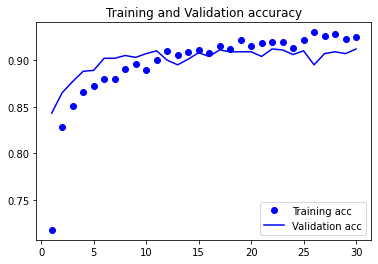

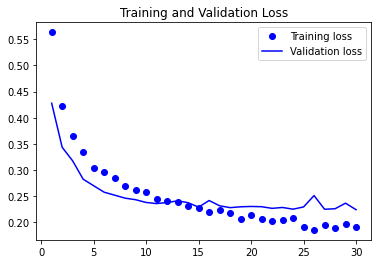

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## 미세 조정

미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층과 함께 훈련하는 것, 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라 불림

네트워크 미세 조정 과정

1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가
2. 기반 네트워크를 동결
3. 새로 추가한 네트워크를 훈련
4. 기반 네트워크에서 일부 층의 동결을 해제
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [17]:
#기반 네트워크에서 일부 층의 동결을 해제, 여기서는 block1부터 block4까지 동결, block5가 학습 대상
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
#네트워크 미세 조정
model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(learning_rate=1e-5), metrics = ['acc'])

histroy = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/100


<ipython-input-18-4dde35ff574c>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  histroy = model.fit_generator(train_generator,


100/100 [==============================] - 26s 237ms/step - loss: 0.1903 - acc: 0.9235 - val_loss: 0.2481 - val_acc: 0.9030
Epoch 2/100
100/100 [==============================] - 24s 236ms/step - loss: 0.1606 - acc: 0.9370 - val_loss: 0.2111 - val_acc: 0.9170
Epoch 3/100
100/100 [==============================] - 24s 239ms/step - loss: 0.1409 - acc: 0.9435 - val_loss: 0.2071 - val_acc: 0.9200
Epoch 4/100
100/100 [==============================] - 23s 233ms/step - loss: 0.1255 - acc: 0.9485 - val_loss: 0.2043 - val_acc: 0.9230
Epoch 5/100
100/100 [==============================] - 23s 233ms/step - loss: 0.1002 - acc: 0.9565 - val_loss: 0.2123 - val_acc: 0.9140
Epoch 6/100
100/100 [==============================] - 23s 235ms/step - loss: 0.0934 - acc: 0.9635 - val_loss: 0.2479 - val_acc: 0.9140
Epoch 7/100
100/100 [==============================] - 23s 233ms/step - loss: 0.0863 - acc: 0.9705 - val_loss: 0.2051 - val_acc: 0.9300
Epoch 8/100
100/100 [==============================] - 23s 2

In [ ]:
#그래프가 불규칙하게 보이기 때문에 지수 이동 평균(exponential moving averages) 사용

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss, 'b', label='Smoothed validation loss'))
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (150, 150), batch_size=20, class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc: ', test_acc)

정리
1. 컨브넷은 컴퓨터 비전 작업에 가장 뛰어난 머신 러닝 모델, 아주 작은 데이터셋에서 처음부터 훈련해서 괜찮은 성능을 낼 수 있음
2. 작은 이미지 데이터 셋에서는 데이터 증식 사용하기
3. 특성 추출 방식으로 새로운 데이터셋에 기존 컨브넷을 쉽게 재사용할 수 있음 -> 작은 이미지 데이터셋으로 작업할 때 효과적
4. 특성 추출을 보완하기 위해 미세 조정을 사용할 수 있음